# GAN Painting Transformer

https://github.com/mizumoto-cn/CSCA5642W5



## Introduction

The goal of this competition is to use Generative Adversarial Networks (GANs) to generate images in the style of Monet. GAN is a type of deep learning model that consists of at least two neural networks: a generator model and a discriminator model. The generator's task is to create images, while the discriminator's task is to accurately classify real and generated images. In this competition, our task is to build a GAN to generate 7000 to 10000 images in the style of Monet.

I will use Graph Neural Networks (GNNs) to accomplish this task. GNNs are deep learning models specifically designed to handle graph data. They capture and utilize structural information of graphs by propagating and aggregating information on nodes and edges. This makes GNNs particularly suitable for problems best represented as graphs, such as social network analysis, molecular structure prediction, and tasks requiring capturing relationships between entities.

Furthermore, the evaluation metric for this competition is MiFID (Memorization Informed Fréchet Inception Distance), which is a modification of the Fréchet Inception Distance (FID). A smaller value of MiFID indicates better generated images. FID calculates the distance between the data distributions of real and generated images by extracting features from intermediate layers of an Inception network and modeling the distribution of these features with a multivariate Gaussian distribution. MiFID also takes into account memorization of training samples.

## Setup

In [1]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import torchvision
import shutil
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

### Device Setup and Preprocessing

Here I will set up the backend device together with several parameters.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

print(f"Using {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"PyTorch version: {torch.__version__}")
print(f"Tensor Type: {Tensor}")

# Hyperparameters
batch_size = 6
lr = 2e-4
n_epoches = 100
display_epoch = 10



Using cuda
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
PyTorch version: 2.2.2+cu121
Tensor Type: <class 'torch.cuda.FloatTensor'>


## EDA

Let's build a dataset class for data import, manipulate and storage Monet dataset.

### Data Preprocessing: Pic Transformations

I tried several other methods but everything other than Gaussian Blur will be an overkill for the task.
So I decided to use Gaussian Blur only for the task.

In [3]:
"""
Tranform module:

only applying GaussianBlur to dataset, more transformations seemed like a over-kill

"""
transform = transforms.Compose([
    transforms.Resize((256, 256)),

    # Data augmentation 
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3.)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.15, 0.15, 0.15], std=[0.5, 0.5, 0.5])
])

### Data Class Definition

In [4]:
class PaintingsDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
    
    def __get_crude_item__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        return image

### Data Import

In [5]:
monet_dataset = PaintingsDataset('../input/gan-getting-started/monet_jpg', transform)
photo_dataset = PaintingsDataset('../input/gan-getting-started/photo_jpg', transform)

### Data Loader Initialize

In [6]:
monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True)
photo_loader = DataLoader(photo_dataset, batch_size=batch_size, shuffle=True)

Let's have a look at the size of the Monet Dataset.

In [7]:
print(f"Monet dataset size: {monet_loader.dataset.__len__()}")

Monet dataset size: 300


And we can have a look at the first 3 images of the dataset.

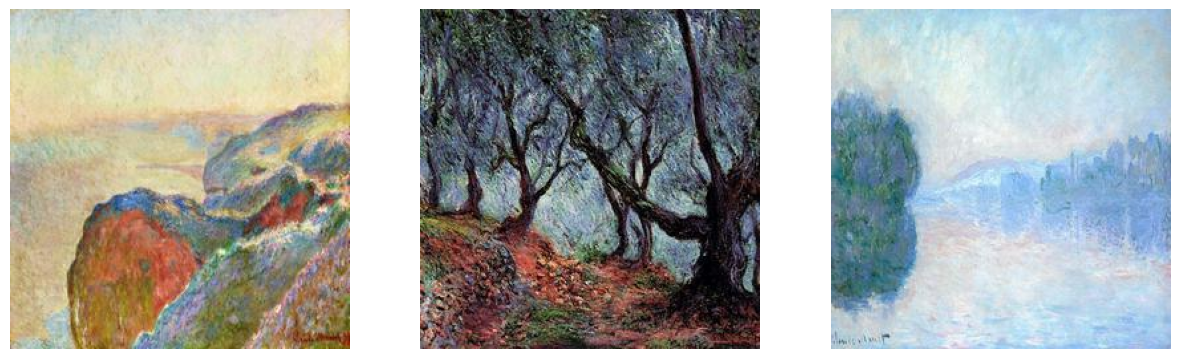

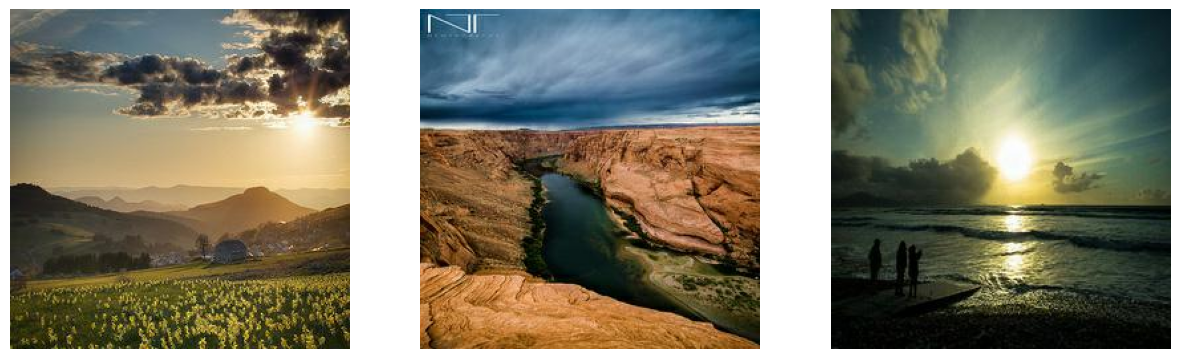

In [8]:
# Display some images
def show_images(dataset, n_images):
    plt.figure(figsize=(15, 15))
    for i in range(n_images):
        image = dataset.__get_crude_item__(i)
        plt.subplot(3, 3, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

show_images(monet_dataset, 3)
show_images(photo_dataset, 3)

### Data Visualization
Let's have a look at the original Monet picture and the transformed Monet picture.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


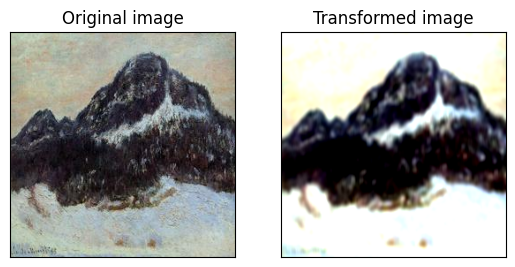

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


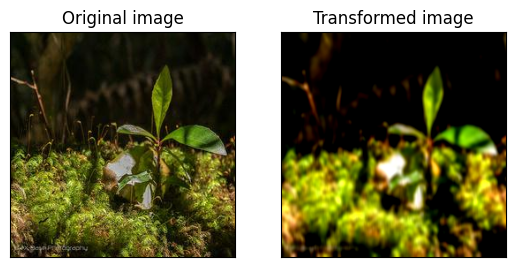

In [9]:
def show_images(n, dataset):
    ex_im_transf = dataset.__getitem__(n)
    ex_im_crude  = dataset.__get_crude_item__(n)

    im_transf = np.squeeze(ex_im_transf) 
    im_crude = np.squeeze(ex_im_crude)

    f, axarr = plt.subplots(1,2)

    for i in range(2):
        axarr[i].axes.get_xaxis().set_visible(False)
        axarr[i].axes.get_yaxis().set_visible(False)

    axarr[1].imshow(im_transf.permute(1, 2, 0))
    axarr[0].imshow(im_crude)
    axarr[1].set_title("Transformed image")
    axarr[0].set_title("Original image")
    plt.show()
    
randn = random.randint(1,298)
show_images(n=randn, dataset=monet_dataset)
show_images(n=randn, dataset=photo_dataset)

## GNN Model

Here I will define a WGNN model for the task.
A WGNN model is a GNN model will contain a Discriminator and a Generator.
With which I can train the model to generate Monet style pictures.

The idea behind these models was (among other aspects) to to try to make the generator more complex than the discriminator, otherwise the discriminator almost always outpaces the generator and the losses in the generator estabilize way too soon.

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        channels_img = 3
        features_d = 64
        
        self.model = nn.Sequential(
            # Input : N x 3 x 256 x 256
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            # Downsampling blocks
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),

            # Upscaling blocks
            self._conv2d_transpose(features_d * 8, features_d * 4, 3, 2, 1, 1),
            self._conv2d_transpose(features_d * 4, features_d * 2, 3, 2, 1, 1),
            self._conv2d_transpose(features_d * 2, features_d, 3, 2, 1, 1),

            # Final convolutional layer
            nn.Conv2d(features_d, 1, kernel_size=3, stride=2, padding=1)
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def _conv2d_transpose(self, in_channels, out_channels, kernel_size, stride, padding, output_padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.model(x)
    
    
class Generator(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(Generator, self).__init__()
        
        channels_img = 3
        features_g = 64
        
        # Initial convolution layer
        self.initial = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels_img, features_g, kernel_size=7, stride=1, padding=0),
            nn.InstanceNorm2d(features_g),
            nn.ReLU(inplace=True)
        )

        # Downsample layers
        self.downsample_blocks = nn.Sequential(
            self._downsample_block(features_g, features_g * 2),
            self._downsample_block(features_g * 2, features_g * 4)
        )

        # Residual blocks
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(features_g * 4) for _ in range(num_residual_blocks)]
        )

        # Upsample layers
        self.upsample_blocks = nn.Sequential(
            self._upsample_block(features_g * 4, features_g * 2),
            self._upsample_block(features_g * 2, features_g)
        )

        # Output layer
        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(features_g, channels_img, kernel_size=7, stride=1, padding=0),
            nn.Tanh()
        )

    def _downsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _upsample_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, 3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

The Discriminator is a simple GNN model with 3 layers, the Generator is a GNN model with 5 layers.
The discriminator will try to classify the images as real or fake, while the generator will try to generate images that the discriminator will classify as real.

### Discriminator and Generator Initialization

In [11]:
G = Generator()
D = Discriminator()

models = [G, D]
for model in models:
    if torch.cuda.is_available():
        model.cuda()

### Loss Functions and Optimizers

Mean Squared Error (MSE) and L1 loss were used as they proved to be more effective and hasty converged toward a local minimum when compared with other loss functions such as Huber loss

Adam optimizer was chosen for the same reason.

In [12]:
gan_loss = nn.MSELoss().cuda()
cycle_loss = nn.L1Loss().cuda()
identity_loss = nn.L1Loss().cuda()

optimizer_G = torch.optim.RMSprop(G.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(D.parameters(), lr=lr)

## Auxiliary Display Function
This function will show you the images before and after generator training, demonstrating the progress of the generator with training.

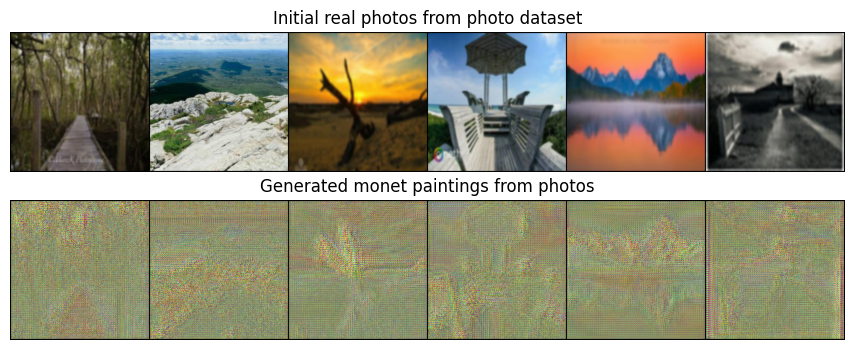

In [13]:
def sample_images(real_X):    
    # turn off some learning parameters in order to evaluate model:
    G.eval()
    
    # transform to tensor and plot images
    real_pic = real_X.type(Tensor)
    artificial_pic = G(real_X).detach()

    ncols = real_X.size(0)
    real_pic_grid = make_grid(real_pic, nrow=ncols, normalize=True)
    artificial_pic_grid = make_grid(artificial_pic, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(2, 1, figsize=(20, 4))  

    axs[0].imshow(real_pic_grid.permute(1, 2, 0).cpu())
    axs[0].set_title("Initial real photos from photo dataset")
    axs[0].axis('off')

    axs[1].imshow(artificial_pic_grid.permute(1, 2, 0).cpu())
    axs[1].set_title("Generated monet paintings from photos")
    axs[1].axis('off')


    plt.show()

real_X = next(iter(photo_loader))
real_Y = next(iter(photo_loader))
sample_images(real_X.to(device))

## Training

The generator and discriminator will be trained in the following way:
- The generator losses will be divided into 2 parts: the loss of the generator itself and the loss of the discriminator, which we will name as `identity loss` and `gan loss` respectively. They both will influence the backend propagation of the different proportions, thus I will add and use them in the optimizer.
- The discriminator losses will also be divided into 2 parts: the `real painting miss classification loss` and the `generated painting miss classification loss`. Basically the loss when misclassifying a fake painting as a true painting and misclassifying a true painting as a fake paining.

In [14]:
CRITIC_ITERATIONS = 5
WEIGHT_CLIP = 0.01
lambda_identity = 5
identity_loss_function = nn.L1Loss()
Gen_losses = []
Dis_losses = []


for epoch in tqdm(range(n_epoches)):
    for i, (real_photo, real_monet) in enumerate(zip(photo_loader, monet_loader)):

        # Prepare the real and generated data
        real_photo = real_photo.type(Tensor)
        real_monet = real_monet.type(Tensor)

        # Train the Critic - We wish to maximize the difference between the fake and the real images - Max(E[critic(real)] - E[critic(fake)])
        for _ in range(CRITIC_ITERATIONS):
            optimizer_D.zero_grad()

            # Generate a batch of images
            artificial_monet = G(real_photo)

            # Critic scores for real and fake images
            critic_real = D(real_monet).reshape(-1)
            critic_fake = D(artificial_monet.detach()).reshape(-1)

            # Calculate the loss for the critic
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            loss_critic.backward(retain_graph=True)
            optimizer_D.step()

            # Weight clipping - to satisfy lipshitz constraint
            for p in D.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train the Generator - We wish to minimize 
        optimizer_G.zero_grad()

        # Since we just updated D, perform another forward pass of all-fake batch through D
        gen_fake = D(artificial_monet).reshape(-1)

        # Calculate G's loss
        loss_G_Wasserstein = -torch.mean(gen_fake)

        # Calculate identity loss
        identity_loss = identity_loss_function(artificial_monet, real_photo)

        # Total generator loss
        loss_G = loss_G_Wasserstein + lambda_identity * identity_loss
        
        loss_G.backward()
        optimizer_G.step()
        
    if (epoch + 1) % display_epoch == 0:
        test_real_photo, test_real_monet = next(iter(zip(photo_loader, monet_loader)))
        sample_images(test_real_photo.type(Tensor))

        print(f'Epoch {epoch + 1}/{n_epoches}')
        print(f'Generator loss: {loss_G.item():.4f}')
        Gen_losses.append(loss_G.item())
        print(f'Discriminator (Critic) loss: {loss_critic.item():.4f}')
        Dis_losses.append(loss_critic.item())

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Plot losses

In [ ]:
def plot_losses(Gen_losses, Dis_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(Gen_losses, label='Generator loss')
    plt.plot(Dis_losses, label='Discriminator loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(Gen_losses, Dis_losses)

From the plot we can see that the generator loss is reaching 1 and discriminator loss is around 0, which is a good sign that the model is learning.

Also we can see directly from the initial-generated images contrasts that pictures turned from photo to paintings gradually as the training epochs go on.

## Output Submission

In [ ]:
# create path to save created monet paintings
transformed_save_dir = '../images'
if not os.path.exists(transformed_save_dir):
    os.makedirs(transformed_save_dir)
    
# freeze some network params to generate imgs
G.eval()


for i, real_photos in enumerate(photo_loader):
    real_photos = real_photos.to(device)
    with torch.no_grad():
        monet_style_imgs = G(real_photos)

    # Save each transformed image
    for j, img in enumerate(monet_style_imgs):
        save_path = os.path.join(transformed_save_dir, f'monet_painting_{i * batch_size + j}.png')
        torchvision.utils.save_image(img, save_path)

print(f"Transformed images are saved in {transformed_save_dir}")

shutil.make_archive("../working/images", 'zip', "../images")

Transformed images will now be saved to `../images` folder for submission.

## Conclusion

In this notebook, I have built a GAN model to generate images in the style of Monet. I used a WGNN model, which contains a discriminator and a generator, to train the model. The generator tries to generate images that the discriminator will classify as real, while the discriminator tries to classify images as real or fake. I used MSE and L1 loss functions and Adam optimizer to train the model. The model was trained for 100 epochs, and the generated images were saved to the `../images` folder for submission.